In [1]:
#Importing Libraries for cleaning
import pandas as pd
import numpy as np

#Importing Libraries for visualization
import seaborn as sns 
import matplotlib.pyplot as plt
from ipywidgets import interactive

#Reading chess_games.cvs dataset
df = pd.read_csv('chess_games.csv')

#Dropping Columns
df = df.drop(columns=['UTCTime', 'WhiteRatingDiff', 'BlackRatingDiff', 'ECO', 'Opening', 'TimeControl', 'UTCDate', 'AN'])

#Filtering Players with Elo less than 2000
df = df[(df['WhiteElo'] >= 2000) | (df['BlackElo'] >= 2000)]

#Checking for null values
df.isnull().value_counts()

#Checking unique values in Event
df['Event'].unique()

#Cleaning Event Column
df['Event'] = df['Event'].str.replace('tournament', '')
df['Event'] = df['Event'].str.replace(' ', '')

#Checking unique values in Result Column
df['Result'].unique()

#Checking the value count of each value in Result Column
df['Result'].value_counts()

#Replacing the values for better understaing and visualization.
df["Result"].replace({"1-0": "White", "0-1": "Black","1/2-1/2": "Draw","*": "Abandoned"}, inplace=True)

#Checking unique values in Termination Column
df['Termination'].unique()

#Adding Index Column
df['IndexC'] = range(1, len(df) + 1)

#Storing Cleaned Data
df.to_csv('CleanedChess.csv')

In [2]:
def f(C):
    #Calculating the number of games repeated among the same players irrespective of the color they chosen
    games_repeated = df.groupby(['White','Black'])['IndexC'].count().loc[lambda x:x>C]
    #Unstacking the above series and filling the empty with Null Values
    games_repeated = games_repeated.unstack(fill_value=0)
    
    #making a symmetric Matrix
    nrepeated = games_repeated + games_repeated.transpose()
    
    #Creating a mask. i.e. an array with same size and type filled with zeros
    z_arr = np.zeros_like(nrepeated)
    z_arr[np.triu_indices_from(z_arr)] = True
    
    #Eliminating extra column and row which occurs in the visualization
    z_arr = z_arr[1:, :-1]
    corr = nrepeated.iloc[1:,:-1].copy()
    return corr,z_arr
    
def plotting(C = 80):
    z,z_arr = f(C)
    with sns.axes_style("whitegrid"):
        #Plotting Heat Map
        fi, a = plt.subplots(figsize=(7,5))
        a = sns.heatmap(z.fillna(0), mask=z_arr, annot = True, cmap = 'Blues',cbar_kws={"shrink": .7}, fmt='g')

interactive_plot = interactive(plotting,C=(80,100,1))
interactive_plot

interactive(children=(IntSlider(value=80, description='C', min=80), Output()), _dom_classes=('widget-interact'…

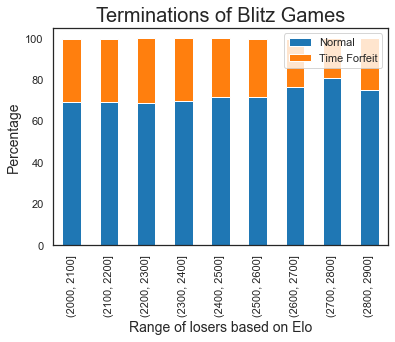

In [3]:
#Creating Custom Ranges
custom_ranges = np.arange(2000, 3000, 100)

#Creating Range Columns
df['WhiteElo_Cut'] = pd.cut(df['WhiteElo'], custom_ranges)
df['BlackElo_Cut'] = pd.cut(df['BlackElo'], custom_ranges)

#Calculating Total Games lost by White and Black
games_total_w = df[(df['Result'] == 'Black')&(df['Termination']!='Rules infraction')&(df['Termination']!='Abadoned')&(df['Event']=='Blitz')].groupby(by ='WhiteElo_Cut')['IndexC'].count()
games_total_b = df[(df['Result'] == 'White')&(df['Termination']!='Rules infraction')&(df['Termination']!='Abadoned')&(df['Event']=='Blitz')].groupby(by ='BlackElo_Cut')['IndexC'].count()


#Calculating games lost by White and Black players in Blitz Tournament by Normal Termination
Normal_w = df[(df['Termination']=='Normal')&(df['Result'] == 'Black')&(df['Event']=='Blitz')].groupby(by ='WhiteElo_Cut')['IndexC'].count()
Normal_b = df[(df['Termination']=='Normal')&(df['Result'] == 'White')&(df['Event']=='Blitz')].groupby(by ='BlackElo_Cut')['IndexC'].count()

#Calculating games lost by White and Black players in Blitz Tournament by Time forfeit Termination
TF_w = df[(df['Termination']=='Time forfeit')&(df['Result'] == 'Black')&(df['Event']=='Blitz')].groupby(by ='WhiteElo_Cut')['IndexC'].count()
TF_b = df[(df['Termination']=='Time forfeit')&(df['Result'] == 'White')&(df['Event']=='Blitz')].groupby(by ='BlackElo_Cut')['IndexC'].count()

#Calculating percentages
Normal_games = (Normal_w + Normal_b)/(games_total_w + games_total_b)*100
TF_games = (TF_w + TF_b)/(games_total_w + games_total_b)*100

#Creating a new data frame
group = zip(Normal_games.values,TF_games.values,np.array(TF_games.index))
losses = pd.DataFrame(data = list(group), columns = ['Normal','Time Forfeit','Elo Loser'])

#Setting Index
losses.set_index('Elo Loser', inplace=True)

#Creating Bar Graph
sns.set_theme(style="white", palette=None)
losses.plot(kind='bar', stacked=True)
plt.title('Terminations of Blitz Games', fontsize=20)
plt.xlabel('Range of losers based on Elo', fontsize=14)
plt.ylabel('Percentage', fontsize=14)
plt.savefig('Bar_grid.png',bbox_inches='tight')
plt.show()